<h1><center><font size="25">Introduction forecasting with skforecast</font></center></h1>

<center><b>Joaquín Amat Rodrigo</b></center>

<center><i>July, 2021</i></center>

## Installation

In [1]:
#!pip install skforecast
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast@v0.1.9
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

## Autoregressive forecaster

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

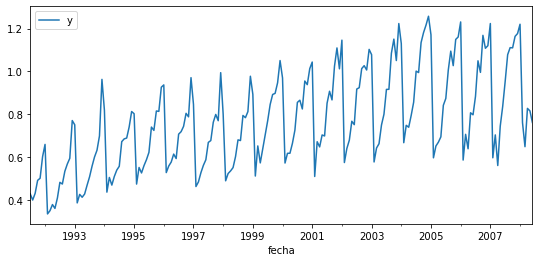

In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
ax.legend();

In [4]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor=LinearRegression(),
                    lags=15
                )

forecaster.fit(y=datos_train)
forecaster

=======================ForecasterAutoreg=======================
Regressor: LinearRegression()
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Exogenous variable: False, None
Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

Test error (mse): 0.011051937043503714


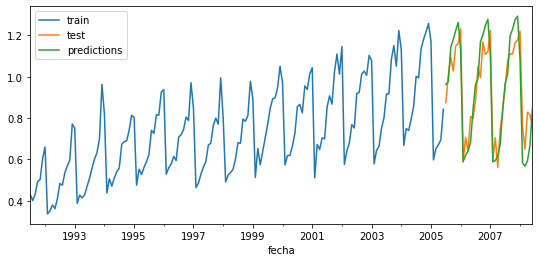

In [5]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [6]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

2021-08-16 12:23:11,772 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:14<00:00,  4.73s/it] 
2021-08-16 12:23:25,972 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.026520
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.026967
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.028092
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.028693
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.029500
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.033252
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.033828
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.034154
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.036539
3,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.036623


In [7]:
# Predictors importance
# ==============================================================================
print(forecaster.get_feature_importances())

[0.58857871 0.10819445 0.06032462 0.02772937 0.02760762 0.01349508
 0.03496535 0.01883128 0.02761474 0.09265878]


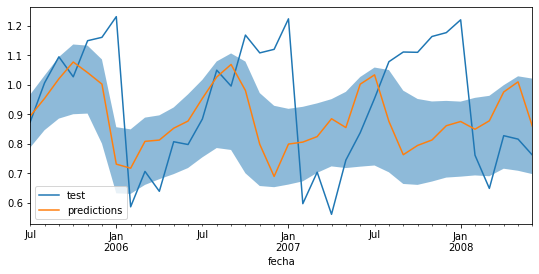

In [8]:
# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [5, 95],
                    n_boot   = 1000
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

Number of observations used for training: 95
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.02150972]


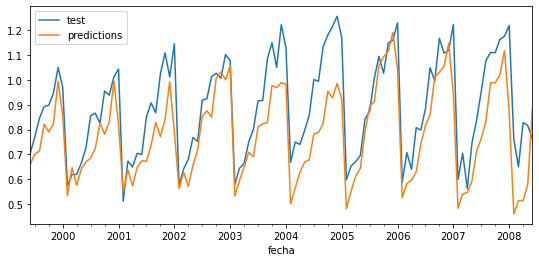

In [9]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=15)

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)
print(metric)

# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest, index=datos_test.index)
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

## Autoreg + 1 exogenous predictor
<br>

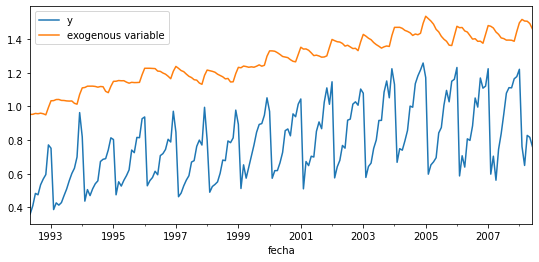

In [10]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variable
# ==============================================================================
datos_exog = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog = datos_exog[10:]
datos = datos[10:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog.plot(ax=ax, label='exogenous variable')
ax.legend();

In [11]:
# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

Test error (mse): 0.020306077140235624


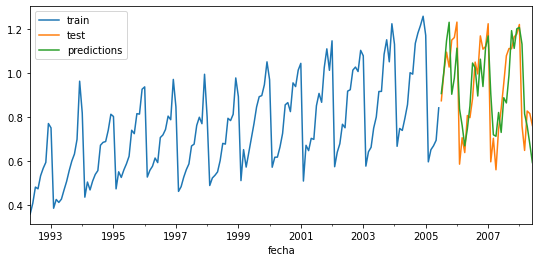

In [12]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [13]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-08-16 12:25:35,429 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:10<00:00,  3.47s/it] 
2021-08-16 12:25:45,835 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.028383
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.028550
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.028952
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.030860
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.035755
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.037170
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.037354
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.039665
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.041344
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.044439


## Autoregressive + n exogenous predictors
<br>

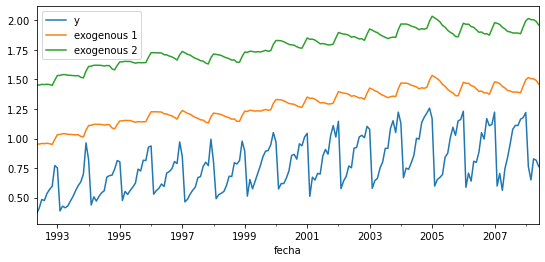

In [14]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variables
# ==============================================================================
datos_exog_1 = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog_2 = datos.rolling(window=10, closed='right').mean() + 1
datos_exog_1 = datos_exog_1[10:]
datos_exog_2 = datos_exog_2[10:]
datos = datos[10:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog_1.plot(ax=ax, label='exogenous 1')
datos_exog_2.plot(ax=ax, label='exogenous 2')
ax.legend();

In [15]:
# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog = np.column_stack((datos_exog_1.values, datos_exog_2.values))
datos_exog_train = datos_exog[:-steps,]
datos_exog_test  = datos_exog[-steps:,]

Test error (mse): 0.020306077140235194


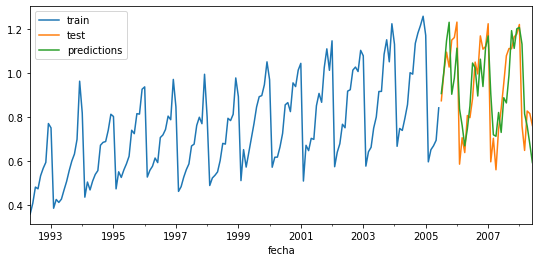

In [16]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)
# Add datetime index
predictions = pd.Series(data=predictions, index=datos_test.index)

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [17]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-08-16 12:25:46,299 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:11<00:00,  3.80s/it] 
2021-08-16 12:25:57,696 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 5, 'n_estimators': 50}



,lags,params,metric
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.025775
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.027541
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.028391
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.029196
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.036057
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.037904
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.039041
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.040024
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.042173
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.042883


## Session info

In [18]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.3.2
numpy               1.21.2
pandas              1.3.2
session_info        1.0.0
skforecast          0.2.0
sklearn             0.24.2
-----
IPython             7.22.0
jupyter_client      6.1.7
jupyter_core        4.6.3
jupyterlab          2.1.3
notebook            6.4.0
-----
Python 3.7.9 (default, Aug 31 2020, 12:42:55) [GCC 7.3.0]
Linux-5.11.0-25-generic-x86_64-with-debian-bullseye-sid
-----
Session information updated at 2021-08-16 12:25


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.